<a href="https://colab.research.google.com/github/sarojkhanal-git/CBEAS_Whole_brain_and_Hippocampal_Segmentation/blob/main/Copy_of_Kfold2_Full_TUNING_Hippo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Libraries Import

In [ ]:
import pandas as pd

In [ ]:
%pip install "monai==1.4.1rc1" -q
#%pip install torchinfo -q
#%pip install thop -q

In [ ]:
!pip install numpy==1.24.3

In [ ]:
import glob
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime


import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim


from monai.config import print_config
from monai.metrics import DiceMetric
from monai.data import DataLoader, Dataset, decollate_batch
from monai.losses import DiceLoss
from monai.networks.nets import SwinUNETR
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    Resize,
    ScaleIntensity,
    ToTensor,
    Lambda,
    EnsureType,
)
from monai.utils import set_determinism
from monai.inferers import sliding_window_inference


from monai.metrics import compute_hausdorff_distance, SurfaceDistanceMetric
from monai.metrics import HausdorffDistanceMetric


#from torchinfo import summary
#from thop import profile


from google.colab import drive
print_config()

MONAI version: 1.4.1rc1
Numpy version: 1.24.3
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: e604d1841fe60c0ffb6978ae4116535ca8d8f34f
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.3
Pillow version: 11.2.1
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.51.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/e

##Drive Mount

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


##Image, Label and FreeSurferColorLUT Directory

In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
image_dir = "MNI_train_data/image_files"
label_dir = "MNI_train_data/label_files_combined"

In [ ]:
lut_path = "FreeSurferColorLUT.txt"

##Image & Labels Extraction and Visualization

In [ ]:
images = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))
labels = sorted(glob.glob(os.path.join(label_dir, "*.nii.gz")))

In [ ]:
len(images), len(labels)

(25, 25)

In [ ]:
def visualize_image(mri_image, label_image, slice_num, array = False):

  if array == False:
    mri_image = nib.load(mri_image).get_fdata()
    label_image =nib.load(label_image).get_fdata()

  df = pd.read_csv(lut_path,sep='\s+', comment = '#', names = ['Label_ID', 'Label_Name', 'R', 'G', 'B', 'A'], usecols = ['Label_ID', 'Label_Name', 'R', 'G', 'B'])

  unique_labels = np.unique(label_image)

  rgb_img = np.zeros((*label_image.shape, 3), dtype = np.uint8)

  for labels in unique_labels:
     rgb_values = df.loc[df['Label_ID'] == labels, ['R', 'G', 'B']].values[0]
     rgb_img[label_image == labels] = rgb_values

  fig, axs = plt.subplots(1, 3, figsize = (15, 15))
  axs[0].imshow(mri_image[slice_num,: ,:], cmap = 'gray')
  axs[0].set_title('MRI Slice')
  axs[0].axis('off')

  axs[1].imshow(rgb_img[slice_num, :, :, :])
  axs[1].set_title('Label Slice')
  axs[1].axis('off')

  axs[2].imshow(mri_image[slice_num, :, :], cmap = 'gray')
  axs[2].imshow(rgb_img[slice_num, :, :, :], alpha = 0.5)
  axs[2].set_title('Overlay')
  axs[2].axis('off')

  plt.show()




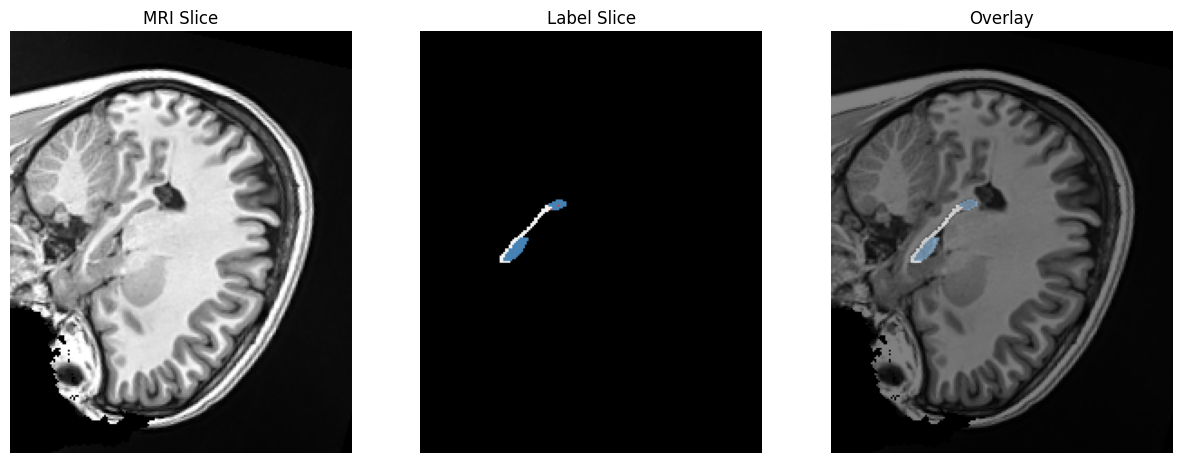

In [ ]:
visualize_image(images[0],labels[0], 75)

##Image Transforms and Custom Dataset

####Transforms

In [ ]:
from monai.transforms import SpatialCrop, CenterSpatialCrop

In [ ]:
img_transforms = Compose([
    LoadImage(image_only=True),
    ToTensor(),
    ScaleIntensity(),
    EnsureChannelFirst(),
    #SpatialCrop(roi_center= (98, 122, 55), roi_size=(128, 128, 128)) #(197, 189, 233)
    CenterSpatialCrop(roi_size=(160, 160, 160))
])

seg_transforms = Compose([
    LoadImage(image_only=True),
    ToTensor(),
    EnsureChannelFirst(),
    #SpatialCrop(roi_center= (98, 122, 55), roi_size=(128, 128, 128)) #(197, 189, 233)
    CenterSpatialCrop(roi_size=(160, 160, 160))
])


In [ ]:
class MyBrainDataset(Dataset):
    def __init__(self, data, img_tfms, seg_tfms):
        super().__init__(data)
        self.img_tfms = img_tfms
        self.seg_tfms = seg_tfms

    def __getitem__(self, idx):
        d = self.data[idx]
        image = self.img_tfms(d["image"])
        label = self.seg_tfms(d["label"])
        return image, label


##Dataset Loading

In [ ]:
data_dicts = [{"image": i, "label": s} for i, s in zip(images, labels)]

#Training on 2nd fold
train_files = data_dicts[:5] + data_dicts[10:]
val_files   = data_dicts[5:10]
print(f"Train Files: {train_files}/n/n")
print(f"Val Files: {val_files}")

print(f"Number of training samples: {len(train_files)}")
print(f"Number of validation samples: {len(val_files)}")


Train Files: [{'image': 'MNI_train_data/image_files/s01_t1w_standard_defaced_MNI.nii.gz', 'label': 'MNI_train_data/label_files_combined/s01_hippolabels_t1w_standard_L_MNI.nii.gz'}, {'image': 'MNI_train_data/image_files/s02_t1w_standard_defaced_MNI.nii.gz', 'label': 'MNI_train_data/label_files_combined/s02_hippolabels_t1w_standard_L_MNI.nii.gz'}, {'image': 'MNI_train_data/image_files/s03_t1w_standard_defaced_MNI.nii.gz', 'label': 'MNI_train_data/label_files_combined/s03_hippolabels_t1w_standard_L_MNI.nii.gz'}, {'image': 'MNI_train_data/image_files/s04_t1w_standard_defaced_MNI.nii.gz', 'label': 'MNI_train_data/label_files_combined/s04_hippolabels_t1w_standard_L_MNI.nii.gz'}, {'image': 'MNI_train_data/image_files/s05_t1w_standard_defaced_MNI.nii.gz', 'label': 'MNI_train_data/label_files_combined/s05_hippolabels_t1w_standard_L_MNI.nii.gz'}, {'image': 'MNI_train_data/image_files/s11_t1w_standard_defaced_MNI.nii.gz', 'label': 'MNI_train_data/label_files_combined/s11_hippolabels_t1w_standard_

In [ ]:
train_ds = MyBrainDataset(train_files, img_transforms, seg_transforms)
val_ds   = MyBrainDataset(val_files,   img_transforms, seg_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, num_workers=2)

In [ ]:
imgt, segt = train_ds[0]
imgt = imgt.squeeze().numpy()
segt = segt.squeeze().numpy()
imgt.shape, segt.shape

((160, 160, 160), (160, 160, 160))

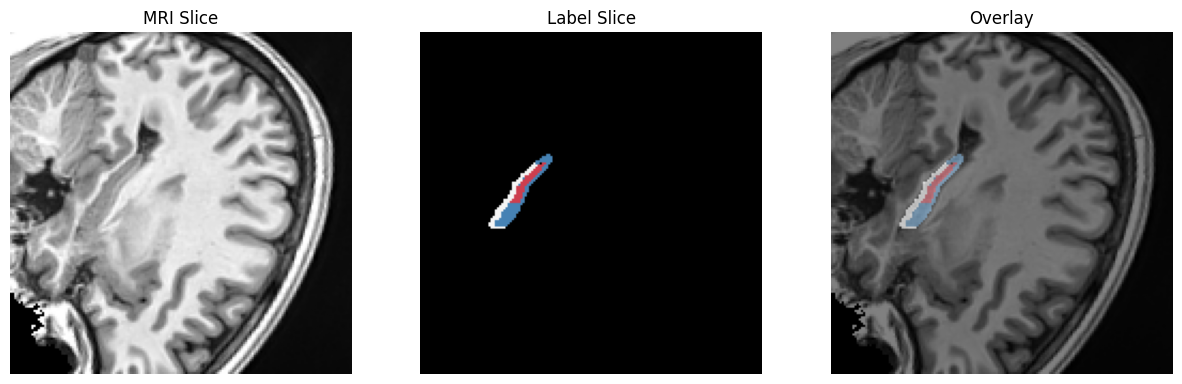

In [ ]:
visualize_image(imgt, segt, 50, array = True)

##Model, Optimizer and Loss Function

In [ ]:
from monai.losses import DiceCELoss

In [ ]:
set_determinism(seed=40)

num_classes = 4

model = SwinUNETR(
    img_size=(160, 160, 160),
    in_channels=1,
    out_channels=num_classes,
    feature_size=24,
    use_checkpoint=True

).cuda()


/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


##Loading Pre-Trained Model

In [ ]:
len(model.state_dict())

159

In [ ]:
pretrained_dict = torch.load('160_24fs_lr-3_best_dice_model.pth')
model_dict = model.state_dict()

# Count total parameters in both models
total_pretrained_params = len(pretrained_dict)
total_current_params = len(model_dict)

# Check which parameters match in name
name_matches = [k for k in pretrained_dict.keys() if k in model_dict]
print(f"Parameters matching by name: {len(name_matches)} out of {total_pretrained_params}")

# Check which parameters match in both name and shape
filtered_dict = {
    k: v
    for k, v in pretrained_dict.items()
    if k in model_dict and model_dict[k].shape == v.shape
}

# Print statistics
print(f"Parameters matching by name and shape: {len(filtered_dict)} out of {total_pretrained_params}")
print(f"Parameters that will NOT be updated: {total_current_params - len(filtered_dict)} out of {total_current_params}")

# Print the specific layers that will NOT be updated
non_updated_layers = [k for k in model_dict.keys() if k not in filtered_dict]
print("\nLayers that will NOT be updated:")
for layer in non_updated_layers:
    print(f"- {layer} with shape {model_dict[layer].shape}")

# Update and load as before
model_dict.update(filtered_dict)
model.load_state_dict(model_dict)
print("\nModel successfully updated!")

Parameters matching by name: 159 out of 159
Parameters matching by name and shape: 157 out of 159
Parameters that will NOT be updated: 2 out of 159

Layers that will NOT be updated:
- out.conv.conv.weight with shape torch.Size([4, 24, 1, 1, 1])
- out.conv.conv.bias with shape torch.Size([4])

Model successfully updated!


#Adapter Layer

##Model Details

In [ ]:

loss_function = DiceCELoss(to_onehot_y=True, softmax=True, lambda_dice=0.7, lambda_ce=0.3, include_background=True)

trainable_params = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=1e-3)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 50, 70], gamma=0.1)

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

hd95_metric = HausdorffDistanceMetric(include_background=False, percentile=95.0, reduction="mean")
asd_metric = SurfaceDistanceMetric(include_background=False, reduction="mean")

post_trans = Compose([
    Activations(softmax=True),
    AsDiscrete(argmax=True, to_onehot=num_classes)
])

to_onehot = AsDiscrete(to_onehot=num_classes)


In [ ]:
#summary(model, input_size=(1, 1, 128, 128, 128))

In [ ]:
'''
input_tensor = torch.randn(1, 1, 128, 128, 128)
flops, params = profile(model, inputs=(input_tensor,))
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")
'''

'\ninput_tensor = torch.randn(1, 1, 128, 128, 128)\nflops, params = profile(model, inputs=(input_tensor,))\nprint(f"FLOPs: {flops}")\nprint(f"Parameters: {params}")\n'

##Functions to load and save model and checkpoints

In [ ]:
def save_best_model(model, best_model_path):
    torch.save(model.state_dict(), best_model_path)

In [ ]:
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [ ]:
def save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, hd95_list, asd_list, train_loss_list, best_metric, best_metric_epoch, checkpoint_path):
    checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    'dice_mean': dice_mean,
    'epoch_list' : epoch_list,
    'val_dice_list' : val_dice_list,
    'train_loss_list' : train_loss_list,
    'hd95_list': hd95_list,
    'asd_list': asd_list,
    'best_metric': best_metric,
    'best_metric_epoch': best_metric_epoch,
    }
    torch.save(checkpoint, checkpoint_path)


In [ ]:
def load_checkpoint(path):
    checkpoint = torch.load(path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    dice_mean = checkpoint['dice_mean']
    epoch_list = checkpoint['epoch_list']
    val_dice_list = checkpoint['val_dice_list']
    hd95_list = checkpoint['hd95_list']
    asd_list = checkpoint['asd_list']
    train_loss_list = checkpoint['train_loss_list']
    best_metric = checkpoint['best_metric']
    best_metric_epoch = checkpoint['best_metric_epoch']
    return epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, hd95_list, asd_list, train_loss_list, best_metric, best_metric_epoch

##Load Checkpoint

In [ ]:
epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, hd95_list, asd_list, train_loss_list, best_metric, best_metric_epoch = load_checkpoint('Train_Data_INFO/Cross_Validation/Fold2_Checkpoint.pth')

##Epochs and Validation

In [ ]:
max_epochs = 80
val_interval = 1

###Run if Checkpoints are not loaded

In [ ]:
train_loss_list = []
val_dice_list   = []
epoch_list      = []
hd95_list = []
asd_list  = []
epoch=0
dice_mean = -1
best_metric = -1
best_metric_epoch = -1

##Train and Validation Loop

In [ ]:
from tqdm import tqdm

In [ ]:
start_epoch=epoch

In [ ]:
import torch.nn.functional as F

In [ ]:
checkpoint_path = 'Train_Data_INFO/Cross_Validation/Fold2_Checkpoint.pth'
best_model_path = 'Train_Data_INFO/Cross_Validation/Fold2_best_dice_model.pth'

#Training Loop
for epoch in range(epoch+1, max_epochs):
    print(f"Epoch [{epoch+1}/{max_epochs}] {datetime.datetime.now()}")
    model.train()
    epoch_loss = 0

    for batch_data in tqdm(train_loader, leave=False):
        inputs, label = batch_data[0].cuda(), batch_data[1].cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    #scheduler.step()
    train_loss_list.append(epoch_loss)
    print(f"  Train loss: {epoch_loss:.4f}")



    # Validation Loop
    if (epoch + 1) % val_interval == 0:
        model.eval()
        dice_vals = []
        with torch.no_grad():
            for val_data in tqdm(val_loader, leave=False):
                val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model, mode="gaussian", overlap=0.5)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)

                val_labels_onehot = [to_onehot(i) for i in decollate_batch(val_labels)]

                hd95_metric(y_pred=val_outputs, y=val_labels_onehot)
                asd_metric(y_pred=val_outputs, y=val_labels_onehot)


        dice_mean = dice_metric.aggregate().item()
        dice_metric.reset()


        hd95_mean = hd95_metric.aggregate().item()
        asd_mean  = asd_metric.aggregate().item()
        hd95_metric.reset()
        asd_metric.reset()

        hd95_list.append(hd95_mean)
        asd_list.append(asd_mean)

        val_dice_list.append(dice_mean)
        epoch_list.append(epoch + 1)
        print(f"  Validation Dice: {dice_mean:.4f}")
        print(f"  Validation HD95 : {hd95_mean:.4f} mm")
        print(f"  Validation ASD  : {asd_mean:.4f} mm")

        # Save the best model
        if dice_mean > best_metric:
            best_metric = dice_mean
            best_HD95 = hd95_mean
            best_ASD  = asd_mean
            best_metric_epoch = epoch + 1
            save_best_model(model, best_model_path)
            print("   Saved new best model")


    if (epoch + 1) % 20 == 0:
      checkpoint_path = f'Train_Data_INFO/Cross_Validation/Fold2_Checkpoint_{epoch}.pth'
    save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, hd95_list, asd_list, train_loss_list, best_metric, best_metric_epoch, checkpoint_path)
print(f"\nTraining complete. Best val Dice: {best_metric:.4f}, HD95: {best_HD95}, ASD: {best_ASD} at epoch {best_metric_epoch}")

Epoch [20/80] 2025-05-25 16:25:30.011290


  Train loss: 0.2705


  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:335: UserWarning: the prediction of class 2 is all 0, this may result in nan/inf distance.
  warnings.warn(


  Validation Dice: 0.6203
  Validation HD95 : 10.5338 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [21/80] 2025-05-25 16:26:36.689076


  Train loss: 0.2613


  Validation Dice: 0.6822
  Validation HD95 : 5.7737 mm
  Validation ASD  : 1.2085 mm
   Saved new best model
Epoch [22/80] 2025-05-25 16:27:23.240929


  Train loss: 0.2539


  Validation Dice: 0.7534
  Validation HD95 : 3.9182 mm
  Validation ASD  : 1.0310 mm
   Saved new best model
Epoch [23/80] 2025-05-25 16:28:09.342289


  Train loss: 0.2432


  Validation Dice: 0.7645
  Validation HD95 : 3.7246 mm
  Validation ASD  : 1.0931 mm
   Saved new best model
Epoch [24/80] 2025-05-25 16:28:55.735330


  Train loss: 0.2390


  Validation Dice: 0.7991
  Validation HD95 : 2.4813 mm
  Validation ASD  : 0.7529 mm
   Saved new best model
Epoch [25/80] 2025-05-25 16:29:41.858736


  Train loss: 0.2290


  Validation Dice: 0.8059
  Validation HD95 : 2.1829 mm
  Validation ASD  : 0.6584 mm
   Saved new best model
Epoch [26/80] 2025-05-25 16:30:28.853809


  Train loss: 0.2208


  Validation Dice: 0.8096
  Validation HD95 : 2.2110 mm
  Validation ASD  : 0.6532 mm
   Saved new best model
Epoch [27/80] 2025-05-25 16:31:15.793134


  Train loss: 0.2076


  Validation Dice: 0.8064
  Validation HD95 : 2.2981 mm
  Validation ASD  : 0.6691 mm
Epoch [28/80] 2025-05-25 16:32:02.599126


  Train loss: 0.2013


  Validation Dice: 0.7973
  Validation HD95 : 2.2041 mm
  Validation ASD  : 0.6767 mm
Epoch [29/80] 2025-05-25 16:32:48.479313


  Train loss: 0.1790


  Validation Dice: 0.8092
  Validation HD95 : 2.1691 mm
  Validation ASD  : 0.6261 mm
Epoch [30/80] 2025-05-25 16:33:34.377589


  Train loss: 0.1562


  Validation Dice: 0.8259
  Validation HD95 : 1.9167 mm
  Validation ASD  : 0.5555 mm
   Saved new best model
Epoch [31/80] 2025-05-25 16:34:20.432043


  Train loss: 0.1413


  Validation Dice: 0.8071
  Validation HD95 : 2.0991 mm
  Validation ASD  : 0.5421 mm
Epoch [32/80] 2025-05-25 16:35:06.358637


  Train loss: 0.1236


  Validation Dice: 0.8160
  Validation HD95 : 2.0534 mm
  Validation ASD  : 0.5247 mm
Epoch [33/80] 2025-05-25 16:35:52.162255


  Train loss: 0.1098


  Validation Dice: 0.8249
  Validation HD95 : 1.9978 mm
  Validation ASD  : 0.5294 mm
Epoch [34/80] 2025-05-25 16:36:38.106442


  Train loss: 0.0992


  Validation Dice: 0.8087
  Validation HD95 : 2.1707 mm
  Validation ASD  : 0.5597 mm
Epoch [35/80] 2025-05-25 16:37:24.283054


  Train loss: 0.0929


  Validation Dice: 0.8215
  Validation HD95 : 1.8988 mm
  Validation ASD  : 0.5431 mm
Epoch [36/80] 2025-05-25 16:38:10.853793


  Train loss: 0.0878


  Validation Dice: 0.8270
  Validation HD95 : 2.0392 mm
  Validation ASD  : 0.5385 mm
   Saved new best model
Epoch [37/80] 2025-05-25 16:38:57.229301


  Train loss: 0.0823


  Validation Dice: 0.8227
  Validation HD95 : 2.1001 mm
  Validation ASD  : 0.5800 mm
Epoch [38/80] 2025-05-25 16:39:43.902630


  Train loss: 0.0835


  Validation Dice: 0.8234
  Validation HD95 : 2.0148 mm
  Validation ASD  : 0.5464 mm
Epoch [39/80] 2025-05-25 16:40:29.848919


  Train loss: 0.0793


  Validation Dice: 0.8174
  Validation HD95 : 2.0781 mm
  Validation ASD  : 0.4830 mm
Epoch [40/80] 2025-05-25 16:41:15.702445


  Train loss: 0.0780


  Validation Dice: 0.8286
  Validation HD95 : 1.9474 mm
  Validation ASD  : 0.5255 mm
   Saved new best model
Epoch [41/80] 2025-05-25 16:42:01.821018


  Train loss: 0.0730


  Validation Dice: 0.8266
  Validation HD95 : 1.9013 mm
  Validation ASD  : 0.5182 mm
Epoch [42/80] 2025-05-25 16:42:47.700843


  Train loss: 0.0672


  Validation Dice: 0.8320
  Validation HD95 : 1.8237 mm
  Validation ASD  : 0.5262 mm
   Saved new best model
Epoch [43/80] 2025-05-25 16:43:33.938163


  Train loss: 0.0662


  Validation Dice: 0.8305
  Validation HD95 : 1.9172 mm
  Validation ASD  : 0.5424 mm
Epoch [44/80] 2025-05-25 16:44:19.963237


  Train loss: 0.0665


  Validation Dice: 0.8272
  Validation HD95 : 1.8833 mm
  Validation ASD  : 0.4990 mm
Epoch [45/80] 2025-05-25 16:45:06.014501


  Train loss: 0.0675


  Validation Dice: 0.8236
  Validation HD95 : 2.0179 mm
  Validation ASD  : 0.5635 mm
Epoch [46/80] 2025-05-25 16:45:52.034406


  Train loss: 0.0651


  Validation Dice: 0.8315
  Validation HD95 : 1.7811 mm
  Validation ASD  : 0.5064 mm
Epoch [47/80] 2025-05-25 16:46:38.064473


  Train loss: 0.0634


  Validation Dice: 0.8320
  Validation HD95 : 1.7747 mm
  Validation ASD  : 0.4984 mm
   Saved new best model
Epoch [48/80] 2025-05-25 16:47:24.844732


  Train loss: 0.0607


  Validation Dice: 0.8303
  Validation HD95 : 1.8199 mm
  Validation ASD  : 0.5540 mm
Epoch [49/80] 2025-05-25 16:48:10.917884


  Train loss: 0.0612


  Validation Dice: 0.8246
  Validation HD95 : 1.8581 mm
  Validation ASD  : 0.5293 mm
Epoch [50/80] 2025-05-25 16:48:56.837505


  Train loss: 0.0599


  Validation Dice: 0.8286
  Validation HD95 : 1.8758 mm
  Validation ASD  : 0.5182 mm
Epoch [51/80] 2025-05-25 16:49:42.870645


  Train loss: 0.0571


  Validation Dice: 0.8318
  Validation HD95 : 1.8438 mm
  Validation ASD  : 0.5202 mm
Epoch [52/80] 2025-05-25 16:50:28.774765


  Train loss: 0.0551


  Validation Dice: 0.8309
  Validation HD95 : 1.8325 mm
  Validation ASD  : 0.4890 mm
Epoch [53/80] 2025-05-25 16:51:14.829186


  Train loss: 0.0555


  Validation Dice: 0.8272
  Validation HD95 : 1.8124 mm
  Validation ASD  : 0.5339 mm
Epoch [54/80] 2025-05-25 16:52:01.158462


  Train loss: 0.0559


  Validation Dice: 0.8318
  Validation HD95 : 1.6785 mm
  Validation ASD  : 0.5110 mm
Epoch [55/80] 2025-05-25 16:52:47.046528


  Train loss: 0.0626


  Validation Dice: 0.8207
  Validation HD95 : 1.9574 mm
  Validation ASD  : 0.5435 mm
Epoch [56/80] 2025-05-25 16:53:33.582451


  Train loss: 0.0645


  Validation Dice: 0.8305
  Validation HD95 : 1.8580 mm
  Validation ASD  : 0.5491 mm
Epoch [57/80] 2025-05-25 16:54:20.202463


  Train loss: 0.0623


  Validation Dice: 0.8283
  Validation HD95 : 1.8104 mm
  Validation ASD  : 0.5490 mm
Epoch [58/80] 2025-05-25 16:55:06.332482


  Train loss: 0.0559


  Validation Dice: 0.8243
  Validation HD95 : 1.8395 mm
  Validation ASD  : 0.5239 mm
Epoch [59/80] 2025-05-25 16:55:52.362997


  Train loss: 0.0552


  Validation Dice: 0.8213
  Validation HD95 : 1.8239 mm
  Validation ASD  : 0.5346 mm
Epoch [60/80] 2025-05-25 16:56:38.443631


  Train loss: 0.0544


  Validation Dice: 0.8209
  Validation HD95 : 1.8747 mm
  Validation ASD  : 0.5734 mm
Epoch [61/80] 2025-05-25 16:57:24.485523


  Train loss: 0.0592


  Validation Dice: 0.8266
  Validation HD95 : 2.0395 mm
  Validation ASD  : 0.5418 mm
Epoch [62/80] 2025-05-25 16:58:10.489279


  Train loss: 0.0573


  Validation Dice: 0.8304
  Validation HD95 : 1.8117 mm
  Validation ASD  : 0.5404 mm
Epoch [63/80] 2025-05-25 16:58:56.461556


  Train loss: 0.0554


  Validation Dice: 0.8277
  Validation HD95 : 1.8059 mm
  Validation ASD  : 0.5161 mm
Epoch [64/80] 2025-05-25 16:59:43.107960


  Train loss: 0.0492


  Validation Dice: 0.8328
  Validation HD95 : 1.7402 mm
  Validation ASD  : 0.5187 mm
   Saved new best model
Epoch [65/80] 2025-05-25 17:00:29.348415


  Train loss: 0.0469


  Validation Dice: 0.8295
  Validation HD95 : 1.8417 mm
  Validation ASD  : 0.5042 mm
Epoch [66/80] 2025-05-25 17:01:15.377427


  Train loss: 0.0468


  Validation Dice: 0.8304
  Validation HD95 : 1.7733 mm
  Validation ASD  : 0.5208 mm
Epoch [67/80] 2025-05-25 17:02:01.418286


  Train loss: 0.0461


  Validation Dice: 0.8312
  Validation HD95 : 1.8472 mm
  Validation ASD  : 0.5242 mm
Epoch [68/80] 2025-05-25 17:02:47.338471


  Train loss: 0.0484


  Validation Dice: 0.8356
  Validation HD95 : 1.7946 mm
  Validation ASD  : 0.5039 mm
   Saved new best model
Epoch [69/80] 2025-05-25 17:03:33.713826


  Train loss: 0.0477


  Validation Dice: 0.8306
  Validation HD95 : 1.7966 mm
  Validation ASD  : 0.5141 mm
Epoch [70/80] 2025-05-25 17:04:19.724977


  Train loss: 0.0475


  Validation Dice: 0.8317
  Validation HD95 : 1.7939 mm
  Validation ASD  : 0.5308 mm
Epoch [71/80] 2025-05-25 17:05:06.364393


  Train loss: 0.0463


  Validation Dice: 0.8295
  Validation HD95 : 1.7053 mm
  Validation ASD  : 0.5296 mm
Epoch [72/80] 2025-05-25 17:05:52.897883


  Train loss: 0.0455


  Validation Dice: 0.8316
  Validation HD95 : 1.7993 mm
  Validation ASD  : 0.5138 mm
Epoch [73/80] 2025-05-25 17:06:38.880889


  Train loss: 0.0433


  Validation Dice: 0.8331
  Validation HD95 : 1.7609 mm
  Validation ASD  : 0.5209 mm
Epoch [74/80] 2025-05-25 17:07:24.907342


  Train loss: 0.0441


  Validation Dice: 0.8265
  Validation HD95 : 1.9004 mm
  Validation ASD  : 0.5573 mm
Epoch [75/80] 2025-05-25 17:08:10.906308


  Train loss: 0.0446


  Validation Dice: 0.8341
  Validation HD95 : 1.7140 mm
  Validation ASD  : 0.5074 mm
Epoch [76/80] 2025-05-25 17:08:56.918318


  Train loss: 0.0459


  Validation Dice: 0.8343
  Validation HD95 : 1.7796 mm
  Validation ASD  : 0.5357 mm
Epoch [77/80] 2025-05-25 17:09:43.159751


  Train loss: 0.0484


  Validation Dice: 0.8333
  Validation HD95 : 1.8689 mm
  Validation ASD  : 0.5388 mm
Epoch [78/80] 2025-05-25 17:10:29.195037


  Train loss: 0.0506


  Validation Dice: 0.8312
  Validation HD95 : 1.8278 mm
  Validation ASD  : 0.5200 mm
Epoch [79/80] 2025-05-25 17:11:15.816376


  Train loss: 0.0492


  Validation Dice: 0.8308
  Validation HD95 : 1.8296 mm
  Validation ASD  : 0.5187 mm
Epoch [80/80] 2025-05-25 17:12:02.404912


  Train loss: 0.0440


  Validation Dice: 0.8326
  Validation HD95 : 1.8960 mm
  Validation ASD  : 0.5385 mm

Training complete. Best val Dice: 0.8356, HD95: 1.7946094274520874, ASD: 0.5038773417472839 at epoch 68


##Plotting of Loss Curves

In [ ]:
len(train_loss_list), len(val_dice_list), len(epoch_list)

(80, 80, 80)

In [ ]:
from matplotlib import rcParams

rcParams['font.weight'] = 'bold'

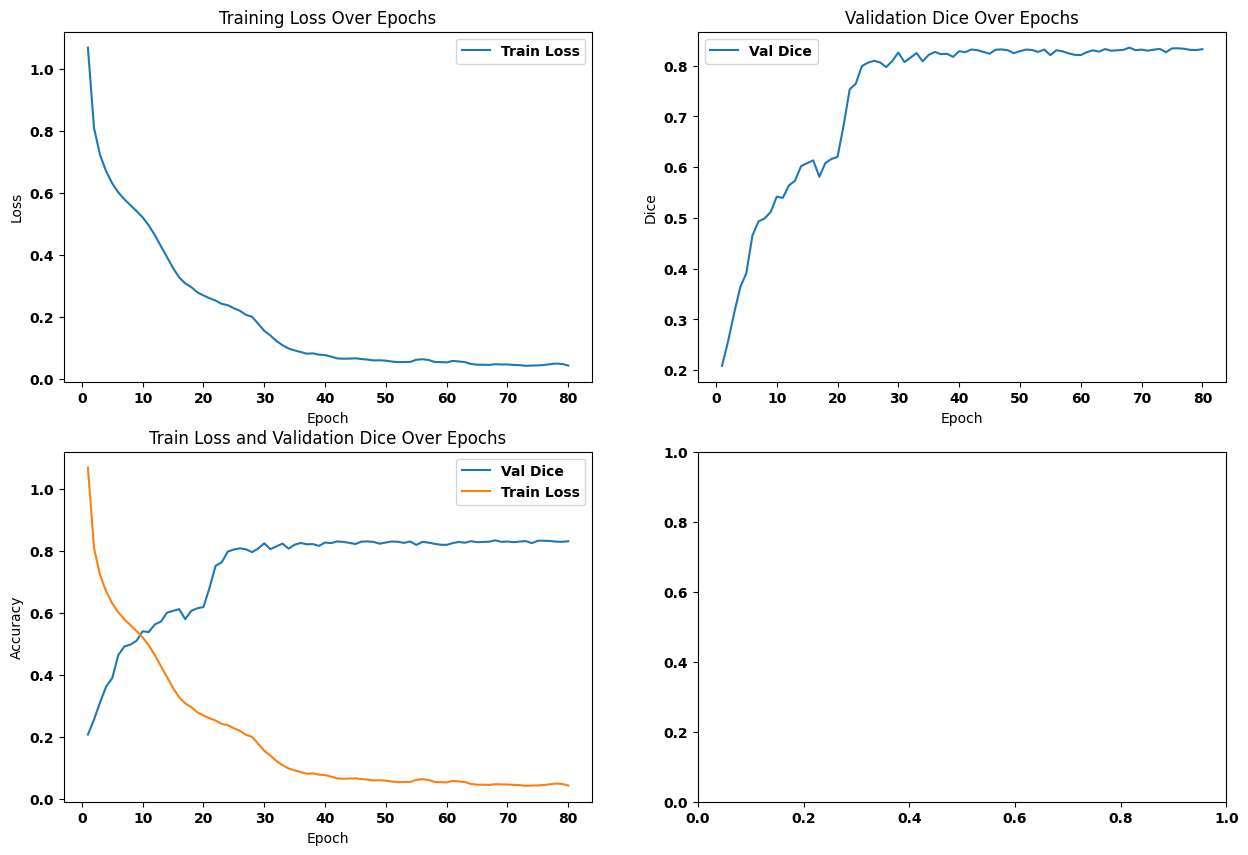

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0 ,0].plot(range(1, max_epochs+1), train_loss_list, label="Train Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].set_title("Training Loss Over Epochs")
axs[0, 0].legend()

axs[0, 1].plot(epoch_list, val_dice_list, label="Val Dice")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Dice")
axs[0, 1].set_title("Validation Dice Over Epochs")
axs[0, 1].legend()

"""
axs[1, 0].plot(range(1, max_epochs+1), 1 - np.array(train_loss_list[:]), label="Train Accuracy")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].set_title("Training Accuracy Over Epochs")
axs[1, 0].legend()
"""

axs[1, 0].plot(epoch_list, val_dice_list, label="Val Dice")
axs[1, 0].plot(range(1, max_epochs+1), train_loss_list, label="Train Loss")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].set_title("Train Loss and Validation Dice Over Epochs")
axs[1, 0].legend()

plt.show()

In [ ]:

df = pd.DataFrame({'Max_Epoch': epoch,
                     "Epoch_list": epoch_list,
                     "Validation_List": val_dice_list,
                     "HD95_List": hd95_list,
                     "ASD_List": asd_list,
                     "Train_Loss_List": train_loss_list,
                     "Best_Dice": best_metric,
                     "Best_Dice_Epoch": best_metric_epoch,
                    "Best_HD95": best_HD95,
                    "Best_ASD": best_ASD,
                    "Best_Metric_Epoch": best_metric_epoch})

file_path = "Train_Data_INFO/Cross_Validation/Kfold2_Full_tuning_data_info.csv"

df.to_csv(file_path, index=False)
print(f"File saved to: {os.path.abspath(file_path)}")

File saved to: /content/drive/MyDrive/Train_Data_INFO/Cross_Validation/Kfold2_Full_tuning_data_info.csv


##Model Evaluation

In [ ]:
# Model Evaluation
model.load_state_dict(torch.load(best_model_path))
model.eval()

def dice_score(pred, target, num_classes):
    """
    Calculate Dice score for each class and the combined hippocampus structure.
    """
    dice_scores = torch.zeros(num_classes, device=pred.device)

    for class_idx in range(num_classes):
        pred_mask = (pred == class_idx).float()
        target_mask = (target == class_idx).float()

        intersection = (pred_mask * target_mask).sum()
        pred_volume = pred_mask.sum()
        target_volume = target_mask.sum()

        if pred_volume + target_volume == 0:
            dice_scores[class_idx] = 1.0
        else:
            dice_scores[class_idx] = (2 * intersection) / (pred_volume + target_volume)

    hippocampus_classes = [1, 2, 3]
    pred_hippocampus = torch.zeros_like(pred, device=pred.device)
    target_hippocampus = torch.zeros_like(target, device=target.device)

    for class_idx in hippocampus_classes:
        pred_hippocampus = pred_hippocampus + (pred == class_idx).float()
        target_hippocampus = target_hippocampus + (target == class_idx).float()

    pred_hippocampus = (pred_hippocampus > 0).float()
    target_hippocampus = (target_hippocampus > 0).float()

    intersection = (pred_hippocampus * target_hippocampus).sum()
    pred_volume = pred_hippocampus.sum()
    target_volume = target_hippocampus.sum()

    if pred_volume + target_volume == 0:
        hippocampus_dice = 1.0
    else:
        hippocampus_dice = (2 * intersection) / (pred_volume + target_volume)

    return dice_scores, hippocampus_dice

# Validation with Dice, HD95, and ASD
test_dice_list = []
test_hd95_list = []
test_asd_list = []
class_dice = {'hippocampus': [], 'CA1': [], 'CA4DG': [], 'subiculum': []}
class_hd95 = {'hippocampus': [], 'CA1': [], 'CA4DG': [], 'subiculum': []}
class_asd = {'hippocampus': [], 'CA1': [], 'CA4DG': [], 'subiculum': []}

to_onehot = AsDiscrete(to_onehot=num_classes)

with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model, mode="gaussian", overlap=0.5)

        # Convert logits to one-hot format
        val_outputs_post = [post_trans(i) for i in decollate_batch(val_outputs)]
        val_labels_onehot = [to_onehot(i) for i in decollate_batch(val_labels)]

        # Convert to class indices for Dice score computation
        val_outputs_indices = torch.argmax(val_outputs, dim=1)

        # Calculate Dice scores
        dice_scores, hippocampus_dice = dice_score(val_outputs_indices, val_labels, num_classes=4)
        class_dice['hippocampus'].append(hippocampus_dice.item())
        class_dice['CA1'].append(dice_scores[1].item())
        class_dice['CA4DG'].append(dice_scores[2].item())
        class_dice['subiculum'].append(dice_scores[3].item())
        test_dice_list.append(dice_scores.mean().item())

        # Compute overall HD95 and ASD
        hd95_metric(y_pred=val_outputs_post, y=val_labels_onehot)
        asd_metric(y_pred=val_outputs_post, y=val_labels_onehot)
        test_hd95_list.append(hd95_metric.aggregate().item())
        test_asd_list.append(asd_metric.aggregate().item())
        hd95_metric.reset()
        asd_metric.reset()

        # Compute per-class HD95 and ASD
        for class_idx in [1, 2, 3]:
            pred_mask = (val_outputs_indices == class_idx).float()  # Shape: [1, 160, 160, 160]
            target_mask = (val_labels == class_idx).float()        # Shape: [1, 160, 160, 160]
            # Convert to one-hot format: [num_classes, 160, 160, 160]
            pred_onehot = torch.zeros((num_classes, 160, 160, 160), device=pred_mask.device)
            target_onehot = torch.zeros((num_classes, 160, 160, 160), device=target_mask.device)
            for i in range(num_classes):
                pred_onehot[i] = (pred_mask == i).float().squeeze(0)  # Squeeze batch dim
                target_onehot[i] = (target_mask == i).float().squeeze(0)  # Squeeze batch dim
            hd95_metric(y_pred=[pred_onehot], y=[target_onehot])
            asd_metric(y_pred=[pred_onehot], y=[target_onehot])
            class_hd95[['CA1', 'CA4DG', 'subiculum'][class_idx-1]].append(hd95_metric.aggregate().item())
            class_asd[['CA1', 'CA4DG', 'subiculum'][class_idx-1]].append(asd_metric.aggregate().item())
            hd95_metric.reset()
            asd_metric.reset()

        # Compute hippocampus combined HD95 and ASD
        hippocampus_classes = [1, 2, 3]
        pred_hippocampus = torch.zeros_like(val_outputs_indices, device=val_outputs_indices.device)
        target_hippocampus = torch.zeros_like(val_labels, device=val_labels.device)
        for class_idx in hippocampus_classes:
            pred_hippocampus = pred_hippocampus + (val_outputs_indices == class_idx).float()
            target_hippocampus = target_hippocampus + (val_labels == class_idx).float()
        pred_hippocampus = (pred_hippocampus > 0).float()  # Shape: [1, 160, 160, 160]
        target_hippocampus = (target_hippocampus > 0).float()  # Shape: [1, 160, 160, 160]
        # Convert to one-hot format for binary (background vs. hippocampus): [2, 160, 160, 160]
        pred_hippocampus_onehot = torch.zeros((2, 160, 160, 160), device=pred_hippocampus.device)
        target_hippocampus_onehot = torch.zeros((2, 160, 160, 160), device=target_hippocampus.device)
        pred_hippocampus_onehot[0] = (pred_hippocampus == 0).float().squeeze(0)
        pred_hippocampus_onehot[1] = pred_hippocampus.squeeze(0)
        target_hippocampus_onehot[0] = (target_hippocampus == 0).float().squeeze(0)
        target_hippocampus_onehot[1] = target_hippocampus.squeeze(0)
        hd95_metric(y_pred=[pred_hippocampus_onehot], y=[target_hippocampus_onehot])
        asd_metric(y_pred=[pred_hippocampus_onehot], y=[target_hippocampus_onehot])
        class_hd95['hippocampus'].append(hd95_metric.aggregate().item())
        class_asd['hippocampus'].append(asd_metric.aggregate().item())
        hd95_metric.reset()
        asd_metric.reset()

        print(f"Validation - Mean Dice: {test_dice_list[-1]:.4f}, HD95: {test_hd95_list[-1]:.4f}, ASD: {test_asd_list[-1]:.4f}")
        print(f"Hippocampus: Dice: {class_dice['hippocampus'][-1]:.4f}, HD95: {class_hd95['hippocampus'][-1]:.4f}, ASD: {class_asd['hippocampus'][-1]:.4f}")
        print(f"CA1: Dice: {class_dice['CA1'][-1]:.4f}, HD95: {class_hd95['CA1'][-1]:.4f}, ASD: {class_asd['CA1'][-1]:.4f}")
        print(f"CA4DG: Dice: {class_dice['CA4DG'][-1]:.4f}, HD95: {class_hd95['CA4DG'][-1]:.4f}, ASD: {class_asd['CA4DG'][-1]:.4f}")
        print(f"Subiculum: Dice: {class_dice['subiculum'][-1]:.4f}, HD95: {class_hd95['subiculum'][-1]:.4f}, ASD: {class_asd['subiculum'][-1]:.4f}\n")

# Calculate final statistics
def get_stats(values):
    return np.mean(values), np.std(values)

overall_dice_mean, overall_dice_std = get_stats(test_dice_list)
hippocampus_dice_mean, hippocampus_dice_std = get_stats(class_dice['hippocampus'])
ca1_dice_mean, ca1_dice_std = get_stats(class_dice['CA1'])
ca4dg_dice_mean, ca4dg_dice_std = get_stats(class_dice['CA4DG'])
sub_dice_mean, sub_dice_std = get_stats(class_dice['subiculum'])

overall_hd95_mean, overall_hd95_std = get_stats(test_hd95_list)
hippocampus_hd95_mean, hippocampus_hd95_std = get_stats(class_hd95['hippocampus'])
ca1_hd95_mean, ca1_hd95_std = get_stats(class_hd95['CA1'])
ca4dg_hd95_mean, ca4dg_hd95_std = get_stats(class_hd95['CA4DG'])
sub_hd95_mean, sub_hd95_std = get_stats(class_hd95['subiculum'])

overall_asd_mean, overall_asd_std = get_stats(test_asd_list)
hippocampus_asd_mean, hippocampus_asd_std = get_stats(class_asd['hippocampus'])
ca1_asd_mean, ca1_asd_std = get_stats(class_asd['CA1'])
ca4dg_asd_mean, ca4dg_asd_std = get_stats(class_asd['CA4DG'])
sub_asd_mean, sub_asd_std = get_stats(class_asd['subiculum'])

print("\nFinal Test Metrics:")
print(f"Overall: Dice: {overall_dice_mean:.4f} ± {overall_dice_std:.4f}, HD95: {overall_hd95_mean:.4f} ± {overall_hd95_std:.4f}, ASD: {overall_asd_mean:.4f} ± {overall_asd_std:.4f}")
print(f"Hippocampus: Dice: {hippocampus_dice_mean:.4f} ± {hippocampus_dice_std:.4f}, HD95: {hippocampus_hd95_mean:.4f} ± {hippocampus_hd95_std:.4f}, ASD: {hippocampus_asd_mean:.4f} ± {hippocampus_asd_std:.4f}")
print(f"CA1: Dice: {ca1_dice_mean:.4f} ± {ca1_dice_std:.4f}, HD95: {ca1_hd95_mean:.4f} ± {ca1_hd95_std:.4f}, ASD: {ca1_asd_mean:.4f} ± {ca1_asd_std:.4f}")
print(f"CA4DG: Dice: {ca4dg_dice_mean:.4f} ± {ca4dg_dice_std:.4f}, HD95: {ca4dg_hd95_mean:.4f} ± {ca4dg_hd95_std:.4f}, ASD: {ca4dg_asd_mean:.4f} ± {ca4dg_asd_std:.4f}")
print(f"Subiculum: Dice: {sub_dice_mean:.4f} ± {sub_dice_std:.4f}, HD95: {sub_hd95_mean:.4f} ± {sub_hd95_std:.4f}, ASD: {sub_asd_mean:.4f} ± {sub_asd_std:.4f}")

Validation - Mean Dice: 0.8402, HD95: 1.8540, ASD: 0.4660
Hippocampus: Dice: 0.8866, HD95: 1.7321, ASD: 0.4779
CA1: Dice: 0.8076, HD95: 1.4142, ASD: 0.5078
CA4DG: Dice: 0.7725, HD95: 1.4142, ASD: 0.5093
Subiculum: Dice: 0.7811, HD95: 2.7337, ASD: 0.3809

Validation - Mean Dice: 0.8371, HD95: 1.6882, ASD: 0.4387
Hippocampus: Dice: 0.8891, HD95: 1.4142, ASD: 0.4719
CA1: Dice: 0.7959, HD95: 1.4142, ASD: 0.5573
CA4DG: Dice: 0.7906, HD95: 2.2361, ASD: 0.3173
Subiculum: Dice: 0.7623, HD95: 1.4142, ASD: 0.4415

Validation - Mean Dice: 0.8589, HD95: 1.4714, ASD: 0.4414
Hippocampus: Dice: 0.8969, HD95: 1.4142, ASD: 0.4666
CA1: Dice: 0.8324, HD95: 1.4142, ASD: 0.5156
CA4DG: Dice: 0.7828, HD95: 2.0000, ASD: 0.4149
Subiculum: Dice: 0.8205, HD95: 1.0000, ASD: 0.3937

Validation - Mean Dice: 0.8266, HD95: 1.7154, ASD: 0.5377
Hippocampus: Dice: 0.8781, HD95: 2.0000, ASD: 0.5192
CA1: Dice: 0.8010, HD95: 1.7321, ASD: 0.5124
CA4DG: Dice: 0.7652, HD95: 2.0000, ASD: 0.5540
Subiculum: Dice: 0.7407, HD95: 1

In [ ]:
metrics_dict = {
    'Region': ['Overall', 'Hippocampus', 'CA1', 'CA4DG', 'Subiculum'],
    'Dice_Mean': [overall_dice_mean, hippocampus_dice_mean, ca1_dice_mean, ca4dg_dice_mean, sub_dice_mean],
    'Dice_Std': [overall_dice_std, hippocampus_dice_std, ca1_dice_std, ca4dg_dice_std, sub_dice_std],
    'HD95_Mean': [overall_hd95_mean, hippocampus_hd95_mean, ca1_hd95_mean, ca4dg_hd95_mean, sub_hd95_mean],
    'HD95_Std': [overall_hd95_std, hippocampus_hd95_std, ca1_hd95_std, ca4dg_hd95_std, sub_hd95_std],
    'ASD_Mean': [overall_asd_mean, hippocampus_asd_mean, ca1_asd_mean, ca4dg_asd_mean, sub_asd_mean],
    'ASD_Std': [overall_asd_std, hippocampus_asd_std, ca1_asd_std, ca4dg_asd_std, sub_asd_std]
}

metrics_df = pd.DataFrame(metrics_dict)

metrics_file_path = "Train_Data_INFO/Cross_Validation/Fold2_Full_Tuning_test_metrics.csv"

metrics_df.to_csv(metrics_file_path, index=False)
print(f"Final test metrics saved to: {os.path.abspath(metrics_file_path)}")

Final test metrics saved to: /content/drive/MyDrive/Train_Data_INFO/Cross_Validation/Fold2_Full_Tuning_test_metrics.csv


In [ ]:
model.eval()
test_dice_list = []
with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model, mode="gaussian", overlap=0.5)
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
        dice_metric(y_pred=val_outputs, y=val_labels)

        dice_mean = dice_metric.aggregate().item()
        test_dice_list.append(dice_mean)
        dice_metric.reset()
        print(f"Validation Dice: {dice_mean:.4f}")

test_dice_mean = np.mean(test_dice_list)
std_dev = np.std(test_dice_list)
print(f"\nTest Dice: {test_dice_mean:.4f}, Std Dev: {std_dev:.4f}")

Validation Dice: 0.8342
Validation Dice: 0.8146
Validation Dice: 0.8180
Validation Dice: 0.8399
Validation Dice: 0.8590

Test Dice: 0.8332, Std Dev: 0.0161


In [ ]:
# Load the model
#load_model(model, '/content/drive/MyDrive/Checkpoints/150_epoch_1e-2_best_model.pth')
model.eval()
# Get validation data
val_img, val_seg = val_ds[0]
val_img_ = val_img.unsqueeze(0).cuda()

# Generate prediction
with torch.no_grad():
    pred_logits = model(val_img_)
    # Apply softmax to get probabilities
    pred_probs = torch.softmax(pred_logits, dim=1)
    # Get the class with highest probability
    pred_label = torch.argmax(pred_probs, dim=1, keepdim=True)  # shape [1,1,D,H,W]

# Convert to numpy for visualization
pred_label_np = pred_label.squeeze().cpu().numpy()  # shape [D,H,W]
val_img_np = val_img.squeeze().numpy()              # shape [D,H,W]
val_seg_np = val_seg.squeeze().numpy()              # ground truth

print("Predicted label map shape:", pred_label_np.shape)

Predicted label map shape: (160, 160, 160)


In [ ]:
print(np.unique(pred_label_np), len(np.unique(pred_label_np)))

[0 1 2 3] 4


###Changing contiguous labels to standard labels

In [ ]:
STD_LABEL_VALUES = np.array([0, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 24, 26, 28, 30, 31, 41, 42, 43, 44, 46, 47, 49, 50, 51, 52, 53, 54, 58, 60, 62, 63, 77, 80, 85, 251, 252, 253, 254, 255])

In [ ]:
std_pred_label = STD_LABEL_VALUES[pred_label_np]
std_val_seg = STD_LABEL_VALUES[val_seg_np.astype('int')]

In [ ]:
np.unique(std_pred_label)

array([0, 2, 3, 4])

###Visualization of Predicted and Ground Truth Labels

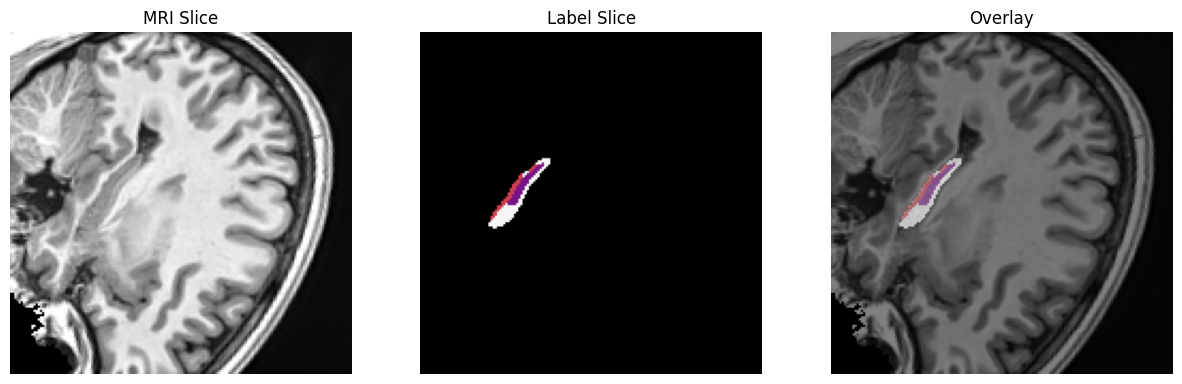

In [ ]:
#Prediction
visualize_image(val_img_np,std_pred_label, 50, array = True)

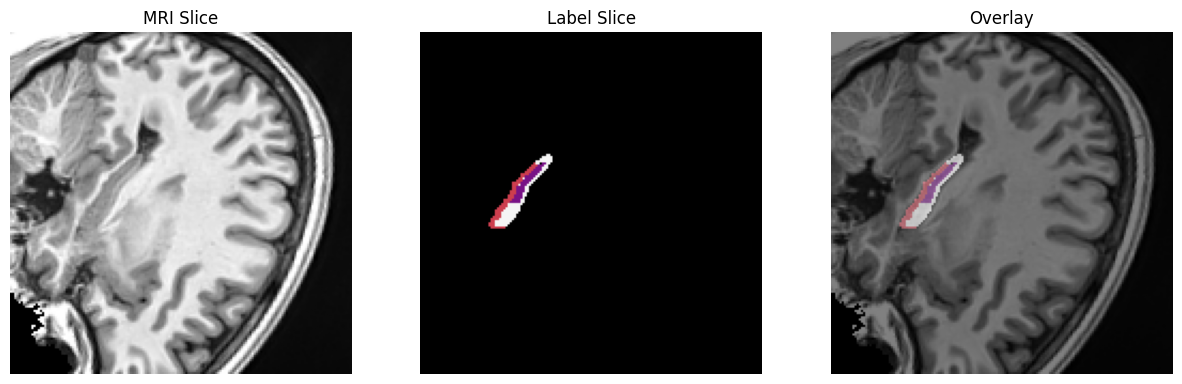

In [ ]:
#Ground Truth
visualize_image(val_img_np, std_val_seg, 50, array = True)